In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import time

# Define robot shape
R = 25      # unit: mm, radius of the wheels
L = 100     # unit: mm, length of the robot
W = 90      # unit: mm, width of the robot

C = 2 * math.pi * R    # unit: mm, circumference of the wheels

# Maximum values
wmax = 1    # unit: RPS (rotations per second), maximum angular velocity of the wheels
vx_max = vy_max = C * wmax    # unit: mm/s, maxium velocity of the robot in the direction of x and y
wmax_robot = 2 * C * wmax / W      # unit: rad/s, maximum angular velocity of the robot. = max{C * (w1 - w2) / W} = 2 * C * wmax / W (w1, w2 unit: RPS)

show_animation = True


In [2]:
m = 5000   # unit: mm, length of the map
n = 5000   # unit: mm, width of the map

In [4]:
obstacles = []
# borders of the map
obstacles.append([2 * L, 20, 20, m - 2 * L, -90])
obstacles.append([0, 2 * L, 20, n - 2 * L, 0])
obstacles.append([0, n, 20, m, -90])
obstacles.append([m - 20, 0, 20, n, 0])

# restrictions in parking spot
obstacles.append([800, 500, 400, 1500, 0])
obstacles.append([800, 3000, 400, 1500, 0])
obstacles.append([1900, 500, 200, 1200, 0])
obstacles.append([2900, 500, 200, 1200, 0])
obstacles.append([1900, 3300, 200, 1200, 0])
obstacles.append([2900, 3300, 200, 1200, 0])
obstacles.append([2000, 2600, 200, 2000, -90])
obstacles.append([3500, 4100, 200, 1200, -90])
obstacles.append([3500, 1100, 200, 1200, -90])

In [5]:
# start state: s0 = [x0, y0, θ0]
s0 = [0, 0, 0]

# target state: st = [xt, yt, θt]
st = [4000, 3000, math.pi / 2]

In [6]:
# RRT node
class Node():
    def __init__(self, state):
        self.state = state
        self.path = []
        self.parent = None
        self.t = 0

In [7]:
def find_closestNode(V, xt):
    # V: a set of RRT points. V = {v}, v is a Node class, v.state = (x, y, theta) in C-space
    # xt: a single target point. xt = (x_t, y_t, theta_t)
    # Return: the closest node to the target point xt inside the set V

    closest_node = V[0]
    # By dividing by the maximum value of each motion, the weighted distance of three different dimensions that the robot can reach is normalized.
    # numpy.linalg.norm
    weighted_dist = ((V[0].state[0] - xt[0]) / vx_max) ** 2 + ((V[0].state[1] - xt[1]) / vy_max) ** 2 + ((V[0].state[2] - xt[2]) / wmax_robot) ** 2

    for point in V:
        dist = ((point.state[0] - xt[0]) / vx_max) ** 2 + ((point.state[1] - xt[1]) / vy_max) ** 2 + ((point.state[2] - xt[2]) / wmax_robot) ** 2
        if dist < weighted_dist:
            closest_node = point
            weighted_dist = dist
    return closest_node

In [8]:
def generate_trajectory(xi, xt):
    trajectory = []
    trajectory.append(xi)

    # control inputs of two wheels
    inputs = []

    # remaining time within one second, updated after each step
    remain_time = 1

    # end point of each step
    end = [xi[0], xi[1], 0]

    # start-to-goal vector
    diff_x = xt[0] - xi[0]
    diff_y = xt[1] - xi[1]
    diff_dist = math.sqrt(diff_x ** 2 + diff_y ** 2)

    # angle between +x and start-to-goal vector, angle ∈ [-pi, pi]
    angle = np.arctan2(diff_y, diff_x)

    # step 1: rotate towards (or back to) the target position
    diff_angle = (xi[2] - angle) % math.pi
    if diff_angle <= math.pi / 2:
        end[2] = xi[2] - diff_angle
    else:
        end[2] = xi[2] + (math.pi - diff_angle)
    end[2] = end[2] % (2 * math.pi)
    trajectory.append(end)
    # print(trajectory)

    # calculate remaining time after step 1
    required_time = diff_angle % (math.pi / 2) / wmax_robot
    remain_time = 1 - required_time
    inputs.append((-wmax, wmax, required_time))

    # calculate required time for step 2
    required_time = diff_dist / C
    end = [end[0], end[1], end[2]]      # update list pointer

    # if not enough time for step 2 (to reach the target after rotation)
    if remain_time < required_time:
        dist = remain_time * C
        end = [xi[0] + dist * math.cos(angle), xi[1] + dist * math.sin(angle), end[2]]
        trajectory.append(end)
        inputs.append((wmax, wmax, remain_time))
        # print(trajectory)

    # if the robot has enough time to reach the target after rotation
    else:
        end = [xt[0], xt[1], end[2]]
        trajectory.append(end)
        inputs.append((wmax, wmax, required_time))
        # print(trajectory)

        # for the remaining time, do the step 3 (rotate to the orientation of the target state)
        end = [xt[0], xt[1], end[2]]
        remain_time -= required_time
        diff_angle = end[2] - xt[2]
        if math.pi <= diff_angle <= 2 * math.pi:
            diff_angle = diff_angle - 2 * math.pi
        elif -2 * math.pi <= diff_angle <= -math.pi:
            diff_angle = diff_angle + 2 * math.pi
        required_time = abs(diff_angle) / wmax_robot

        # if have enough time for step 3, then arrive at the target state
        if remain_time >= required_time:
            trajectory.append(xt)
            inputs.append((-wmax, wmax, required_time))
            # print(trajectory)

        # if not enough time for step 3
        else:
            if 0 <= diff_angle <= math.pi:
               end[2] = end[2] - wmax_robot * remain_time
            else:
                end[2] = end[2] + wmax_robot * remain_time
            trajectory.append(end)
            inputs.append((-wmax, wmax, remain_time))
            # print(trajectory)
    return trajectory, inputs

In [9]:
# cross product of vector p1-to-p2 and p1-to-p3
def cross(p1, p2, p3):
    # p1, p2, p3 are points in the configuration space
    # can also use np.cross(p2 - p1, p3 - p1)[2] to return the same value
    x1 = p2[0] - p1[0]
    y1 = p2[1] - p1[1]
    x2 = p3[0] - p1[0]
    y2 = p3[1] - p1[1]
    return x1 * y2 - x2 * y1

# determine whether two line segments are intersecting
def isIntersec(p1, p2, p3, p4):
    # (p1, p2) defines line 1, (p3, p4) defines line 2
    # If there is an intersection p0, then p0 is on both lines, so min{p1, p2} <= p0 <= max{p1, p2} and min{p3, p4} <= p0 <= max{p3, p4} are satisfied for both x component and y component
    if (max(p1[0], p2[0]) >= min(p3[0], p4[0]) 
        and max(p3[0], p4[0]) >= min(p1[0], p2[0]) 
        and max(p1[1], p2[1]) >= min(p3[1], p4[1]) 
        and max(p3[1], p4[1]) >= min(p1[1], p2[1])): 

        # if two line segments are intersecting, p3 and p4 are in different sides of the line (p1, p2), p1 and p2 are in different sides of the line (p3, p4)
        if (cross(p1, p2, p3) * cross(p1, p2, p4) <= 0
           and cross(p3, p4, p1) * cross(p3, p4, p2) <= 0):
            result = True
        else:
            result = False
    else:
        result = False
    return result

# determine whether two rectangles have intersections
def isCollisionRectangle(Rectangle1, Rectangle2):
    # Rectangle: [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    # four corners must be clockwise or anticlockwise

    collision = False
    for i in range(4):
        for j in range(4):
            collision = collision or isIntersec(Rectangle1[i], Rectangle1[(i + 1) % 4], Rectangle2[j], Rectangle2[(j + 1) % 4])
            if collision:
                break
        if collision:
            break
    return collision

# determine whether the trajectory is collision free
def isCollisionTrajectory(trajectory, obstacles):
    collision = False
    n = len(trajectory)
    for i in range(n - 1):
        x = trajectory[i][0]
        y = trajectory[i][1]
        z = trajectory[i][2]
        x1 = trajectory[i + 1][0]
        y1 = trajectory[i + 1][1]
        z1 = trajectory[i + 1][2]

        # divide the trajectory into certain steps (10 steps for now), treat all motion curves as small line segments
        steps = 10
        for j in range(steps):
            xt = j * (x1 - x) / (steps - 1) + x
            yt = j * (y1 - y) / (steps - 1) + y
            zt = j * (z1 - z) / (steps - 1) + z

            # four vertices of the robot
            p1 = [xt + R * math.cos(zt) + W / 2 * math.sin(zt), yt + R * math.sin(zt) - W / 2 * math.cos(zt)]
            p2 = [p1[0] - L * math.cos(zt), p1[1] - L * math.sin(zt)]
            p3 = [p2[0] - W * math.sin(zt), p2[1] + W * math.cos(zt)]
            p4 = [p3[0] + L * math.cos(zt), p3[1] + L * math.sin(zt)]

            for obstacle in obstacles:
                w = obstacle[2]
                h = obstacle[3]
                zeta = obstacle[4] / 180 * math.pi
                # four vertices of the obstacle
                p5 = [obstacle[0], obstacle[1]]
                p6 = [p5[0] - h * math.sin(zeta), p5[1] + h * math.cos(zeta)]
                p7 = [p6[0] + w * math.cos(zeta), p6[1] + w * math.sin(zeta)]
                p8 = [p7[0] + h * math.sin(zeta), p7[1] - h * math.cos(zeta)]

                # determine whether the trajectory is collision free
                collision = collision or isCollisionRectangle([p1, p2, p3, p4], [p5, p6, p7, p8])
    return collision

In [10]:
def RRT(s0, s1, obstacles):
    V = [Node(s0)]
    end = Node(s0)

    # while can't move from present end to the target state in one second
    while ((end.state[0] - s1[0]) / vx_max) ** 2 + ((end.state[1] - s1[1]) / vy_max) ** 2 + ((end.state[2] - s1[2]) / wmax_robot) ** 2 >= 1:

        # generate a random point in the configuration space
        randompoint = [random.uniform(0, m), random.uniform(0, n), random.uniform(0, 2 * math.pi)]
        start = find_closestNode(V, randompoint)

        # generate a trajectory from the closest start point to the random end point
        trajectory = generate_trajectory(start.state, randompoint)[0]

        # if not collision, add it into V
        if not isCollisionTrajectory(trajectory, obstacles):
            end = Node(trajectory[-1])
            end.parent = start
            V.append(end)
        if len(V) > 10000:
            break
    # print(len(V))

    trajectory = [end.state]
    while (end.parent != None):
        trajectory.append(end.parent.state)
        end = end.parent
    return trajectory, V


In [11]:
def plotTrajectory(trajectory, ax):
    for point in trajectory:
        # plot the robot
        x = point[0] + R * math.cos(point[2]) - W / 2 * math.sin(point[2]) - L * math.cos(point[2])
        y = point[1] + R * math.sin(point[2]) + W / 2 * math.cos(point[2]) - L * math.sin(point[2])
        rec = plt.Rectangle((x, y), W, L, angle = point[2] * 180 / math.pi - 90, color = 'b')
        ax.add_patch(rec)
    return ax

def plotTrajectory1(trajectory, ax):
    for point in trajectory:
        # plot the robot
        x = point[0] + R * math.cos(point[2]) - W / 2 * math.sin(point[2]) - L * math.cos(point[2])
        y = point[1] + R * math.sin(point[2]) + W / 2 * math.cos(point[2]) - L * math.sin(point[2])
        rec = plt.Rectangle((x, y), W, L, angle = point[2] * 180 / math.pi - 90, color = 'r')
        ax.add_patch(rec)
    return ax

def plotObstacles(obstacles, ax):
    for obstacle in obstacles:
        rec = plt.Rectangle((obstacle[0], obstacle[1]), obstacle[2], obstacle[3], angle = obstacle[4], color = 'k')
        ax.add_patch(rec)
    return ax

def plotPoint(point, ax):
    # plot arrow
    plt.arrow(point[0], point[1], 0.5 * np.cos(point[2]),0.5 * np.sin(point[2]), color = 'r', width = m / 100)
    # plot center point 
    plt.plot(point[0], point[1], 'bo')
    # plot robot 
    x = point[0] + R * math.cos(point[2]) - W / 2 * math.sin(point[2]) - L * math.cos(point[2])
    y = point[1] + R * math.sin(point[2]) + W / 2 * math.cos(point[2]) - L * math.sin(point[2])
    rec = plt.Rectangle((x, y), W, L, angle = point[2] * 180 / math.pi - 90, color = 'b')
    ax.add_patch(rec)
    return ax

In [14]:
def trajectory_time(trajectory):
    t = 0
    for i in range(len(trajectory) - 1):
        dx = trajectory[i + 1][0] - trajectory[i][0]
        dy = trajectory[i + 1][1] - trajectory[i][1]
        dz = trajectory[i + 1][2] - trajectory[i][2]
        t += math.sqrt(dx ** 2 + dy ** 2) / vx_max + dz / wmax_robot
    return t

# test performance of RRT
def test(s0, s1, RRT, obstacles):
    print("Target state:       " + str(s1))

    start = time.time()
    trajectory, V = RRT(s0, s1, obstacles)
    end = time.time()
    # Calculation time that RRT needed to find a trajectory
    print("Calculation time:   " + str(end - start) + "s")

    # Calculate number of nodes needed to find a trajectory
    space = len(V)
    print("Number of nodes:    " + str(space))

    # Calculate time that the robot needed to go using the generated RRT trajectory
    t = trajectory_time(trajectory)
    print("Robot running time: " + str(t) + "s")

    # plot trajectory figure
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    # plot the map
    plt.xlim([0, m])
    plt.ylim([0, n])
    plt.xticks(np.arange(0, m + 1, m / 5))
    plt.yticks(np.arange(0, n + 1, n / 5))
    plt.grid()
    # plot obstacles
    plotObstacles(obstacles, ax)

    # plot start and goal statee
    plotPoint(s0, ax)
    plotPoint(s1, ax)
    # plot trajectory
    plotTrajectory(trajectory, ax)

    plt.axis("square")

Target state:       [200, 200, 0]
Calculation time:   0.01427316665649414s
Number of nodes:    3
Robot running time: 1.1s


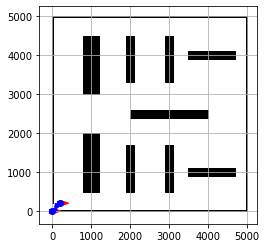

In [15]:
test(s0, [200,200,0], RRT, obstacles)

Target state:       [2000, 2000, 0]
Calculation time:   8.609843015670776s
Number of nodes:    808
Robot running time: 29.816906267519784s


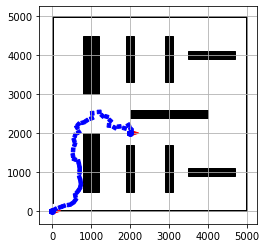

In [16]:
test(s0, [2000,2000,0], RRT, obstacles)

Target state:       [4000, 4500, 0]
Calculation time:   15.546513319015503s
Number of nodes:    1461
Robot running time: 54.37225194989524s


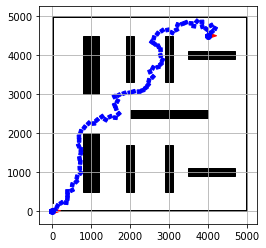

In [17]:
test(s0, [4000,4500,0], RRT, obstacles)

In [18]:
def RRTstar(s0, s1, obstacles):
    V = [Node(s0)]
    end = Node(s0)
    while ((end.state[0] - s1[0]) / vx_max) ** 2 + ((end.state[1] - s1[1]) / vy_max) ** 2 + ((end.state[2] - s1[2]) / wmax_robot) ** 2 >= 1:     
        # get a random point            
        randompoint = [random.uniform(0, m), random.uniform(0, n), random.uniform(0, 2 * math.pi)]
        # find the closest node to the random point
        start = find_closestNode(V, randompoint)
        # generate a trajectory from the closest starting point to the random point
        trajectory = generate_trajectory(start.state, randompoint)[0]
        # start.t
        mintime = trajectory_time(trajectory) + start.t
        # if not collision, add it into V
        if not isCollisionTrajectory(trajectory, obstacles):
            end = Node(trajectory[-1])
            end.parent = start
            end.t = mintime
            # check if end has a better parent
            for node in V:
                trajectory1 = generate_trajectory(node.state, end.state)[0]
                if trajectory1[-1] == end.state and trajectory_time(trajectory1) + node.t < end.t:
                    end.parent = node
                    end.t = trajectory_time(trajectory1) + node.t
            # check if end is a better parent
            for node in V:
                trajectory1 = generate_trajectory(end.state, node.state)[0]
                if not isCollisionTrajectory(trajectory1, obstacles):
                    if  trajectory1[-1] == node.state and end.t + trajectory_time(trajectory1)  < node.t:
                        node.parent = end
                        node.t = end.t + trajectory_time(trajectory1)
            V.append(end)

    trajectory = [end.state]
    while (end.state != s0):
        trajectory.append(end.parent.state)
        end = end.parent
    return trajectory, V

Target state:       [4000, 4500, 0]
868
Calculation time:   2278.8870601654053s
Number of nodes:    868
Robot running time: 52.775395203561445s


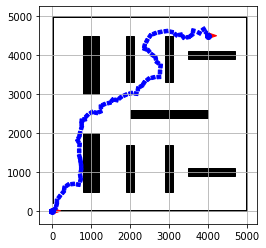

In [19]:
test(s0, [4000,4500,0], RRTstar, obstacles)